#Lecture 15: Simulated Annealing

AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University

------


# Announcements

- final projects:
    - please register your team
    - register until tomorrow to get optimal support
    - teams of 4 are ok, but the project has to scale
    
    
- HW5 grading is finished, will go out later today
- Late days have been fixed and will be reported as total number from now on
- Please keep in mind to not exceed 4 late days


- HW7 is out


- How many of you have upgraded to Ipython 4?

- Feedback: Schedule update

- Unfortunately also a serious remark on plagiarism


In [38]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from IPython import display

# Introduction
Simulated Annealing is one of the most popular techniques for global optimization. 
In physical annealing, a system is first heated to a melting state and then cooled down slowly.
If the process of cooling is slow so the system reaches equilibrium, the system will eventually
settle down to the lowest energy state when the temperature is zero. 
Algorithmically the objective function for the optimization is the energy function 
of an imaginary physical system that mimics the physical annealing process, such as at the end 
the global minimum of the system is reached. 

### A little diversion
Every density function can be rewritten in this way:

$$p(x) = e^{-(-\log(p(x))}$$

Call energy density $E(x)=-\log{p(x)}$

Aim to simulate from

$$p(x\vert T) = e^{-\frac{1}{T} E(x)}$$

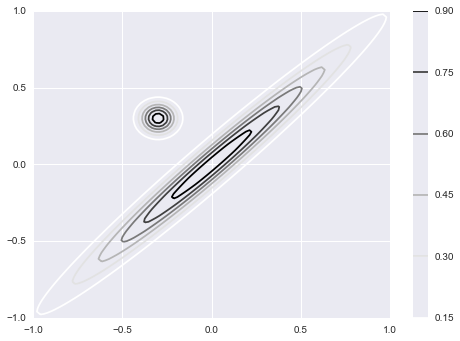

In [2]:
## FUNCTIONS 
# target distribution p(x) 

ee=0.01
p = lambda x,y: np.exp(-(x-y)**2 / (2*ee) - (x+y)**2/2) + np.exp( -(x+.30)**2/0.01)*np.exp( -(y-.30)**2/0.01)

xx= np.linspace(-1,1,100)
yy= np.linspace(-1,1,100)

M = np.empty((100,100))
i=0
for x in xx:
    j=0
    for y in yy:
        M[j,i]=p(x,y)
        j +=1
    i +=1
    
    
plt.contour(xx,yy,M)
plt.colorbar()
plt.show()

Lets try to sample from this function for different temperatures 

In [3]:
# METROPOLIS ALGORITHM 
#create a simple Metropolis Hastings function
def MH_simple(p, n, sig, T, x0, y0):
    x_prev = x0
    y_prev = y0
    x=[x_prev]; y=[y_prev]
    
    k=1
    i=1
    
    while i<n:
        
        x_star = np.random.normal(x_prev, sig)
        y_star = np.random.normal(y_prev, sig)
               
        P_star = p(x_star, y_star)
        P_prev = p(x_prev, y_prev)
        
        U =  np.random.uniform()
        
        E_star = -np.log(P_star)
        E_prev = -np.log(P_prev)
        
        A =  np.exp(-(1.0/T) * (E_star-E_prev))
        if U < A:
            x.append(x_star); y.append(y_star); 
            i = i + 1
            x_prev = x_star; y_prev = y_star
        else :
            x.append(x_prev); y.append(y_prev); 
            #x_prev = x[i] ; y_prev = y[i]  
            i = i + 1
     
            k=k+1
    return np.array(x),np.array(y), k

In [4]:
# number of samples
n = 2000
# step size
sig =.05

#intitialize the sampling. Start somewhere from -1..1
x_vsk = np.random.uniform(low=-1, high=1)
y_vsk= np.random.uniform(low=-1, high=1)

In [5]:
xL,yL, k = MH_simple(p, n, sig=sig, T=0.1, x0=x_vsk, y0=y_vsk)
print "Number of rejected samples for T=0.1: "
print k

xH,yH, k = MH_simple(p, n, sig=sig, T=1.0, x0=x_vsk, y0=y_vsk)
print "Number of rejected samples for T=10.0: "
print k

Number of rejected samples for T=0.1: 
1098
Number of rejected samples for T=10.0: 
478


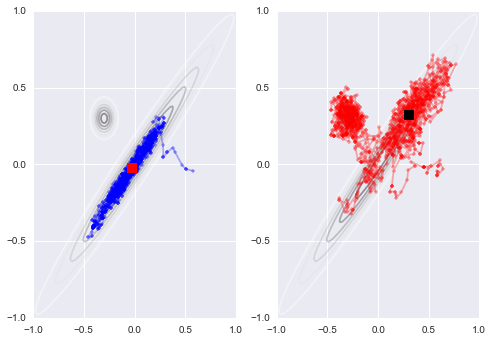

In [6]:
#plt.figure(figsize=[12,8])
plt.subplot(1,2,1)
plt.contour(xx,yy,M, alpha=0.4)
plt.plot(xL,yL, 'b.-', alpha=0.3)
plt.plot(xL[-1],yL[-1], 'rs', ms=10)

plt.subplot(1,2,2)
plt.contour(xx,yy,M, alpha=0.4)
plt.plot(xH,yH, 'r.-', alpha=0.3)
plt.plot(xH[-1],yH[-1], 'ks', ms=10)

In [7]:
# let's sample some more and look at the distribution
n=10000
sig = 0.5
xL,yL, k = MH_simple(p, n, sig=sig, T=0.1, x0=x_vsk, y0=y_vsk)
print "Number of rejected samples for T=0.1: "
print k

xH,yH, k = MH_simple(p, n, sig=sig, T=1.0, x0=x_vsk, y0=y_vsk)
print "Number of rejected samples for T=10.0: "
print k

Number of rejected samples for T=0.1: 
9671
Number of rejected samples for T=10.0: 
8274


As expected, high temperatures (red dots and lines above) can achieve higher mixing where lower temperature chains sample the details much better. This is also the motivation of parallel tempering we will see in the next lecture. 

### Back to simulated annealing
Practically a simulated annealing algorithm works as follows: First, it repeats a loop where the 
temperature is decreased in every loop cycle. Within each loop, the algorithm mimics the cooling process
of the system by making random changes to the system. 
These changes are made by perturbing the current system state by some random amount. Suppose a state with energy $E_i$ and subsequent 
energy state $E_j$.
We denote the change in the energy due to the state change as $\Delta f = E_j-E_i$. The new state is accepted
with probability equal to 

$$A=\exp{ ( -\Delta f/kT)}$$ 

where $k$ is the Boltzmann constant and $T$ is the 
temperature. 

As with MH if the random change produces negative energy difference, the new
state will always be accepted because the probability $p$ is  greater than or equal to one. On the other
hand, if the energy difference is positive, the function value decreases, but the new state is still 
accepted with some probability because the value of $p$ is a fraction. This allows the algorithms to 
escape from local minima. 

The idea was first introduced by Metropolis, Rosenbluth, Teller: Equation of state calculation by fast computing machines, Journ. of Chemical Physics 21, 1087-1092, 1953 to minimize a criterion function on a finite set but it could also used 
 to optimize a continuous set (Kirkpatric et al. 1983, Ackley et al. 1985, and Neal 1993, 1995).
 
 If the lowering of the temperature is sufficiently slow, the state reaches thermal equilibrium at each
 temperature or in the language of MCMC a stationary state. At thermal equilibrium (thermal equilibrium here 
 means we allow the algorithm in the same temperature long enough) the probability 
 distribution is given by 
 
 $$p(X=i) = \frac{1}{Z(T)} \exp{ \left( \frac{-E_i}{kT}\right) }$$
 
 where 
 
 $$Z(T) = \sum_j \exp{ \left( \frac{ -E_j}{kT}\right)}$$
 
 We want to minimize $f(x)$ and for that we can use the equivalence of  the physical
 system and optimization where solution is the state of the physical system, objective function is the 
 energy and control parameter is the temperature. 
 
 Suppose a solution $x_i$ is given, should we change to solution $x_j$? Acceptance 
 criterion is as above, except that now we should use $c=kT$. 
 A transition consists of two steps: 

1. Generate a new solution $x_j$ 
2. Decide whether to accept this new solution 
 
### Algorithm

1. Initialize $x_i,c, L$ where $L$ is the length of the proposal (our step size) (in the example below $L$ is the number of cities to perturb). 
2. Perform $L$ transitions of the type:
    1. Generate a new proposed position $x_j$
    2. If $x_j$ is accepted (according to probability $P$), set $x_i = x_j$.   
3. Update c and L 
4. If the stop criterion is not fulfilled, goto 2.

Unfortunately we need to make some choices. 
1. What is the temperature schedule or the air-conditioning strategy?
   * This involves two parameters: how often we adjust the temperature and by how much. 
2. How large should $L$ be and should that be dynamically adjusted? 
3. Finally what is the stopping criteria? 

### Practical Choices

*  Start with temperature $c_0$ large enough to accept all transitions.
*  Lowering temperature schedule (thermostat). Common choices are
    1. Linear: Temperature decreases as  $c_{k+1} = \alpha c_k$. Typical values are $0.8 < \alpha < 0.99$
    2. Exponential: Temperature decreases as $0.95^{{\rm iteration}}$
    3. Logarithmic: Temperature decreases as $1/\log({\rm iteration})$
* Reannealing interval is the number of points to accept before reannealing (change the temperature). Typical value is 100
* Stopping criterion
    1. Max iterations bounds the number of iterations the algorithm takes
    2. Function tolerance. The algorithm stops if the average change in the objective function after  $m$ iterations (typical $m=100$) is below user specified tolerance
    3. Objective limit. The algorithm stops if the objective function goes below some value  
* Transition jumps, $L$ a.k.a. Annealing function
    1. Fast annealing takes random steps, with size proportional to temperature
    2. Boltzmann annealing takes random steps, with size proportional to square root of temperature


## Travelling Salesman Example

**Problem**: A traveling salesman has to visit $N$ cities and return home, and should take the shortest route.

**Answer**: There are $N!$ different paths to take. For large $N$, it is impossible to test them all. The simulated annealing method provides a solution


In [39]:
x = np.linspace(1,10,5)
y = np.linspace(1,10,5)

tmpx, tmpy =  np.meshgrid(x,y)

cities = np.array([tmpx, tmpy])
cities = np.reshape(cities, (2,-1)).T
print cities.shape

(25, 2)


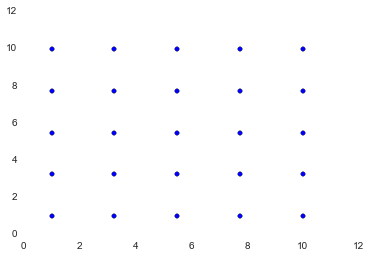

In [40]:
plt.scatter(cities[:,0], cities[:,1])

In [41]:
# the distance between two cities is just
# the norm of the difference vector
def get_distance(city1, city2):
    return np.linalg.norm(city1 - city2)

# the energy for the whole system corresponds to
# the total distance the salesman has to travel
def distance(pathcities):
    distance = 0.
    number_of_cities = pathcities.shape[0]
    
    # loop over all cities
    for j in xrange(number_of_cities):
        if j == number_of_cities - 1: # FINAL POINT CONNECTS WITH THE FIRST ONE
            distance += get_distance( pathcities[j,:], pathcities[0,:] )
        else:
            distance += get_distance( pathcities[j,:], pathcities[j+1,:] )
    return distance
            

In [42]:
# create a new path by swapping the connection between
# n_swaps cities randomly
def changepath(inputcities, n_swaps):
    indices = range(inputcities.shape[0])
    cities = inputcities.copy()
    for i in range(n_swaps):
        swappedCities = swapindex(cities)
        cities=swappedCities.copy()

    return cities

def swapindex(cities):
    indices = range(cities.shape[0])
    # take two random indices to swap
    c1 = np.random.choice(indices)
    c2 = np.random.choice(indices)
    
    while c2 == c1:
        c2 = np.random.choice(indices) 
    
    # remember the cities to swap
    tmp1 = cities[c1,:]
    tmp2 = cities[c2,:]
    
    # do the actual swapping
    changedCities = cities.copy()
    changedCities[c1,:] = tmp2
    changedCities[c2,:] = tmp1
    
    return changedCities

In [43]:
def plot_path(pcities):
    plt.plot(pcities[:,0], pcities[:,1],'o')
    plt.plot(pcities[:,0], pcities[:,1])
    plt.xlim(np.min(pcities[:,0])-1, np.max(pcities[:,0])+1)
    plt.ylim(np.min(pcities[:,1])-1, np.max(pcities[:,1])+1)

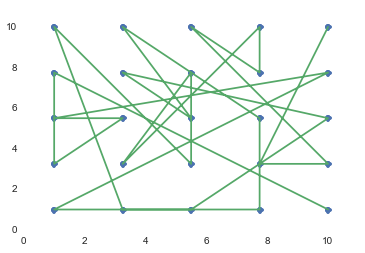

In [44]:
# permute cities to get a random path
rand_ind = np.random.permutation(np.shape(cities)[0])

cities = cities[rand_ind, :]
plot_path(cities)

[[ 8]
 [15]]
[[[  1.   10. ]]

 [[ 10.    5.5]]]


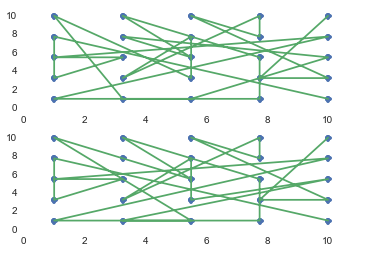

In [45]:
cities_before = cities.copy()

plt.subplot(2,1,1)
plot_path(cities)

cities = changepath(cities, 1)

plt.subplot(2,1,2)
plot_path(cities)

changedIndices = np.argwhere(np.abs(cities_before - cities)[:,0] > 0)
print changedIndices
print cities[changedIndices,:]

In [46]:
# function for simulated annealing
# pathcities: array with our cities represented by their coordinates
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol, otol: tolerance values for stopping
# reannealing: schedule for reheating

def simulated_annealing( pathcities, init_temp, thermostat, ftol, itol, otol, reannealing):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================

    m=10000     
    distsize=otol+1
    dist=[]
    temperature = init_temp   


    N = pathcities.shape[0]
    
    # number of accepted steps
    it = 0                    

    # DISTANCE HERE IS OUR ENERGY 
    prev_E = distance(pathcities)  
    
    # number of iterations
    atp=0
    
    didPlot = False
    
    while it >=0:
        ## NUMBER OF CORNERS IS L
        L = np.max((np.floor(np.sqrt(temperature)).astype(int),1))
        #print "L", L
        #L = 2
        propose_path = changepath(pathcities, L)

        new_E = distance(propose_path)
        deltaE  =  new_E -prev_E 

        if new_E < prev_E:
            pathcities  = propose_path
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E  
            it = it+1
            didPlot = False
            
        elif np.random.rand() < np.exp( -deltaE/temperature):
            pathcities  = propose_path
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E 
            it = it+1
            didPlot = False

        atp =atp +1;  # NUMBER OF ITERATIONS
        
        # check if it is time to cool down
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            #temperature =  temperature/log(it);
            compl_temp=0;
            
            #if we get too cold, reheat
            if temperature < 0.01:
                temperature = 1
        
        if False: #some optional plotting
            if (it % 100 == 0) and not didPlot:       
                display.clear_output()
                plt.plot( dist, '-r')
                display.display(plt.gcf())
                print len(dist)
                print raw_input('Iteration: ' + np.str(atp))
                plt.close()
                didPlot = True
    
        if len(dist)>m and np.std(dist[-m:])/np.mean(dist[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(dist)> 0 and dist[-1] <= otol:
            print 'otol'
            print dist[-1]
            break

    s = pathcities
    return s, dist

In [47]:
# simulated_annealing( pathcities, init_temp, thermostat, ftol, itol, otol, reannealing):
pcities, distances = simulated_annealing(cities, 10.0, 0.95, 0.01, 20000, 0, 10)

print len(distances)

itol
344


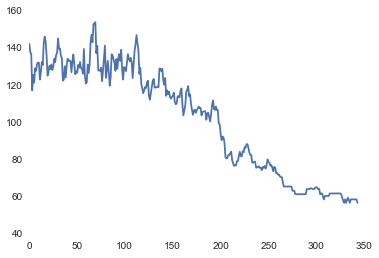

In [48]:
plt.plot(distances)

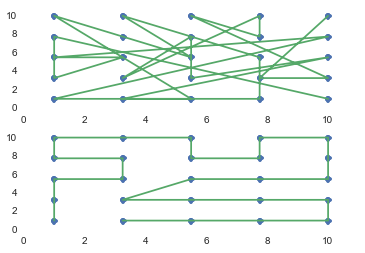

In [49]:
plt.subplot(2,1,1)
plot_path(cities)

plt.subplot(2,1,2)
plot_path(pcities)

In [34]:
# function from HW6 just to demonstrate the effect of the temperature
from scipy.stats import norm
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.30; l2=.70;
ex2 = lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)

[]

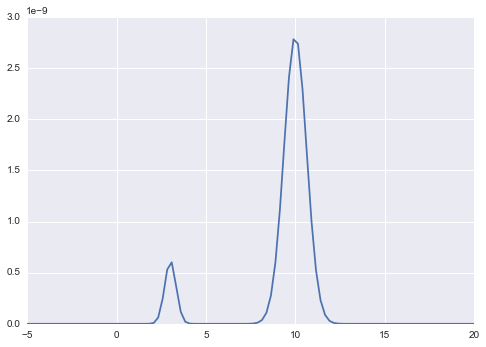

In [37]:
xx = np.linspace(-5,20,100)
T=.1
plt.plot(xx,ex2(xx)**(1/T))
plt.plot()
